In [1]:
import torch
from model.encoder import Encoder
from model.self_interaction import SelfInteraction
from model.cross_interaction import CrossInteraction
from model.guided_backprop import GuidedBackprop
from PIL import Image
import PIL
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
plt.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im=(grayscale_im - im_min) / (im_max - im_min)
    grayscale_im=grayscale_im/np.max(grayscale_im)

    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    grayscale_im=np.repeat(grayscale_im,3,axis=0)*255
    return grayscale_im

def invert_sk(sk):
    sk=sk.split()[0]
    sk=PIL.ImageOps.invert(sk)
    sk=Image.merge('RGB', (sk, sk, sk))
    return sk

In [3]:
ckpt_path='/home/xjq/code/shoe/DLI-Net/ckpt/dli-shoe-v2.pth'
ph_encoder=Encoder('mid').cuda()
sk_encoder=Encoder('mid').cuda()
ckpt=torch.load(ckpt_path)
ph_encoder.load_state_dict(ckpt['ph_encoder'])
sk_encoder.load_state_dict(ckpt['sk_encoder'])
self_interaction=SelfInteraction(0.5)
match=CrossInteraction('2norm')
guided_back=GuidedBackprop(ph_encoder,sk_encoder,self_interaction,match)

In [4]:
ph_path='/home/xjq/code/dataset/qmul-shoe/ShoeV2_photo/1388950015.png'
sk_path='/home/xjq/code/dataset/qmul-shoe/ShoeV2_sketch/png/1388950015_1.png'
norm=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
input_transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), norm])
ph=Image.open(ph_path)
ph_tensor=input_transform(ph)
ph_tensor=ph_tensor.unsqueeze(0).cuda()
sk=Image.open(sk_path)
sk = sk.split()[3]
sk = Image.merge('RGB', (sk, sk, sk))
sk_tensor = input_transform(sk)
sk_tensor=sk_tensor.unsqueeze(0).cuda()
ph_tensor.requires_grad=True
sk_tensor.requires_grad=True

/usr/local/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


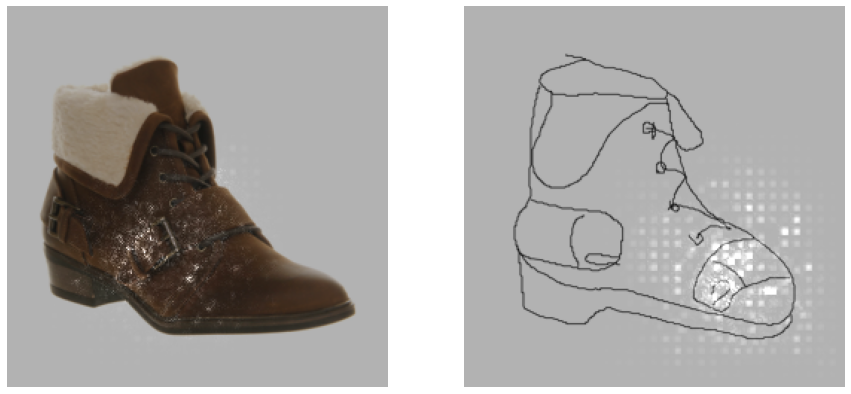

In [5]:
ph_grad,sk_grad=guided_back.generate_gradients(ph_tensor,sk_tensor,103)
grayscale_ph_grads = convert_to_grayscale(ph_grad).transpose(1,2,0)
grayscale_sk_grads = convert_to_grayscale(sk_grad).transpose(1,2,0)
ph=ph.resize((256,256))
sk=invert_sk(sk)
sk=sk.resize((256,256))
back_ph=np.array(ph)*0.7+grayscale_ph_grads
back_sk=np.array(sk)*0.7+grayscale_sk_grads
back_ph=np.clip(back_ph,0,255)
back_sk=np.clip(back_sk,0,255)

back_ph=np.uint8(back_ph)
back_sk=np.uint8(back_sk)
plt.subplot(1, 2, 1)    
plt.imshow(back_ph)
plt.axis('off')
plt.subplot(1, 2, 2) 
plt.imshow(back_sk)
plt.axis('off')
plt.savefig('./backprop.svg')